## Imports

In [1]:
# Standard library imports
import os
import random

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

## Code to generate data

In [2]:
def generate_random_overlap_spike_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations

    # Initialize positions and neuron_data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Initialize train with empty lists for each channel
    train_patterned_overlap = [[] for _ in range(N_channels)]
    
    # Pre-assign at least one firing event for each neuron across the propagations
    preassigned_firings = {neuron_index: random.randint(0, num_propagations - 1) for neuron_index in range(N_channels)}

    # Generate spike times with specified overlap, breaks, and random firing within rows
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)

        for row in range(rows):
            row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
            spike_time_start = row_start
            spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms

            # Randomly decide which neurons in the row will fire (random proportion)
            firing_neurons_in_row = random.sample(range(row * cols, (row + 1) * cols), random.randint(1, cols))

            # Ensure pre-assigned neurons for this propagation are included
            for neuron_index in range(row * cols, (row + 1) * cols):
                if preassigned_firings[neuron_index] == propagation and neuron_index not in firing_neurons_in_row:
                    firing_neurons_in_row.append(neuron_index)

            for neuron_index in firing_neurons_in_row:
                spike_times = np.linspace(spike_time_start, spike_time_end, int(segment_duration_ms / rows / 10))
                train_patterned_overlap[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays
    train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]

    # Create the SpikeData object
    spike_data_patterned_random_firing = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_patterned_random_firing

# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

In [4]:
def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

In [5]:
random_overlap_spike_data = generate_random_overlap_spike_data(
    total_duration_ms=60 * 1000,  # 1 minute
    num_propagations=10,
    rows=16,
    cols=16,
    overlap_duration_ms=30,
    break_duration_ms= 500  # 6 seconds
)

## Code to implement spatial activity profile method

### Helper functions

In [6]:
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles


def create_reverse_rank_lookup(event_ranks):
    """
    Create a reverse lookup table for event ranks.
    
    Parameters:
    - event_ranks: A dictionary mapping (neuron_id, spike_time) to event rank.
    
    Returns:
    - A dictionary mapping event rank to (neuron_id, spike_time).
    """
    reverse_lookup = {rank: (neuron_id, spike_time) for (neuron_id, spike_time), rank in event_ranks.items()}
    return reverse_lookup 

def calculate_event_ranks(spike_data, precision=5):
    # Flatten the list of spikes, rounding spike times, and sort by time
    # Include the original index of each spike for uniqueness
    all_spikes = [(neuron_id, round(spike_time, precision), idx) 
                  for neuron_id, spikes in enumerate(spike_data.train) 
                  for idx, spike_time in enumerate(spikes)]
                  
    # Sort by neuron_id, then rounded spike time, then original index
    all_spikes_sorted = sorted(all_spikes, key=lambda x: (x[1], x[0], x[2]))
    
    # Generate a dictionary with event rank as key, (neuron_id, spike_time) as value
    ranks = {rank: (neuron_id, spike_time) for rank, (neuron_id, spike_time, _) in enumerate(all_spikes_sorted)}
    
    print(f"Total unique events: {len(ranks)}")
    
    return ranks

def precompute_close_neurons(distances, window_size=17.5):
    # Initialize a dictionary to store the indices of close neurons for each neuron
    close_neurons = {}
    
    # Get the total number of neurons based on the distances matrix
    num_neurons = distances.shape[0]
    
    # Iterate over each neuron to find its close neighbors
    for i in range(num_neurons):
        # List comprehension to find neurons within the specified window size
        # Excludes the current neuron itself (i != j) and checks the distance condition
        close_neurons[i] = [
            j for j in range(num_neurons) 
            if i != j and distances[i, j] < window_size
        ]
        
    return close_neurons

def compute_bin_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints

In [15]:
# Function to create distance and angle histograms for all all events
# Looking at 30 PRIOR events

def create_distance_angle_histograms(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        start_rank = max(0, current_event_id - rank_window)
        end_rank = current_event_id

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue
            
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            # print("Distance: ", distance)
            angle = angles[current_neuron_id, other_neuron_id]
            # print("Angle: ", angle)

            if spatial_range[0] <= distance <= spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event




In [16]:
event_ranks = calculate_event_ranks(random_overlap_spike_data)

Total unique events: 49572


In [17]:
histograms = create_distance_angle_histograms(random_overlap_spike_data, event_ranks)

/tmp/ipykernel_15585/1351802137.py:50: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 0 of 49572
Processing event 4957 of 49572
Processing event 9914 of 49572
Processing event 14871 of 49572
Processing event 19828 of 49572
Processing event 24785 of 49572
Processing event 29742 of 49572
Processing event 34699 of 49572
Processing event 39656 of 49572
Processing event 44613 of 49572
Processing event 49570 of 49572
Processing complete


In [21]:
histograms[36]

{'distance': array([30,  0,  0,  0,  0,  0]),
 'angle': array([ 2, 12,  0,  0, 16,  0])}

In [22]:
def compute_average_angle_from_histogram(angle_hist):
    bin_width = 360 / len(angle_hist)
    bin_midpoints = np.arange(0, 360, bin_width) + bin_width / 2
    bin_midpoints_radians = np.radians(bin_midpoints)

    x_components = angle_hist * np.cos(bin_midpoints_radians)
    y_components = angle_hist * np.sin(bin_midpoints_radians)

    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians


# Function to take final histograms and calculate the average distance and angle for each event
def compute_average_distance_angle(final_histograms, bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(82, 1092, bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    # print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        # normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

In [23]:
histograms = create_distance_angle_histograms(random_overlap_spike_data, event_ranks)
average_distances_angles = compute_average_distance_angle(histograms, bins=6)

/tmp/ipykernel_15585/1351802137.py:50: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 0 of 49572
Processing event 4957 of 49572
Processing event 9914 of 49572
Processing event 14871 of 49572
Processing event 19828 of 49572
Processing event 24785 of 49572
Processing event 29742 of 49572
Processing event 34699 of 49572
Processing event 39656 of 49572
Processing event 44613 of 49572
Processing event 49570 of 49572
Processing complete


/tmp/ipykernel_15585/2161906792.py:9: RuntimeWarning: invalid value encountered in scalar divide
  x_mean = np.sum(x_components) / np.sum(angle_hist)
/tmp/ipykernel_15585/2161906792.py:10: RuntimeWarning: invalid value encountered in scalar divide
  y_mean = np.sum(y_components) / np.sum(angle_hist)


In [25]:
def all_events_per_neuron(spike_data, average_distances_angles_per_event):
    all_events_per_neuron = {}

    event_ranks = calculate_event_ranks(spike_data)
    for event_id, averages in average_distances_angles_per_event.items():
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in all_events_per_neuron:
            all_events_per_neuron[neuron_id] = []
        all_events_per_neuron[neuron_id].append(averages)

    return all_events_per_neuron

def average_events_per_neuron(spike_data, average_distances_angles_per_event):
    events_per_neuron = all_events_per_neuron(spike_data, average_distances_angles_per_event)
    positions = get_neuron_positions(spike_data)

    average_events_per_neuron = {}
    for neuron_id, events in events_per_neuron.items():
        angles = [event['angle'] for event in events]
        distances = [event['distance'] for event in events]

        # Calculate vector components
        x_components = [distance * np.cos(angle) for distance, angle in zip(distances, angles)]
        y_components = [distance * np.sin(angle) for distance, angle in zip(distances, angles)]

        # Calculate average vector components
        x_mean = np.mean(x_components)
        y_mean = np.mean(y_components)

        # Convert average vector components to polar coordinates
        average_distance = np.sqrt(x_mean**2 + y_mean**2)
        average_angle = np.arctan2(y_mean, x_mean)

        # # Normalize the average angle to be within 0 to 2*pi radians
        # if average_angle < 0:
        #     average_angle += 2 * np.pi

        average_events_per_neuron[neuron_id] = {'distance': average_distance, 'angle': average_angle, 'position': positions[neuron_id]}

    return average_events_per_neuron

In [27]:
average_events_per_n = average_events_per_neuron(spike_data=random_overlap_spike_data, average_distances_angles_per_event=average_distances_angles)

Total unique events: 49572


/tmp/ipykernel_15585/1351802137.py:50: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


In [36]:
def plot_data(data):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(15, 15))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] / 100  # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    plt.show()

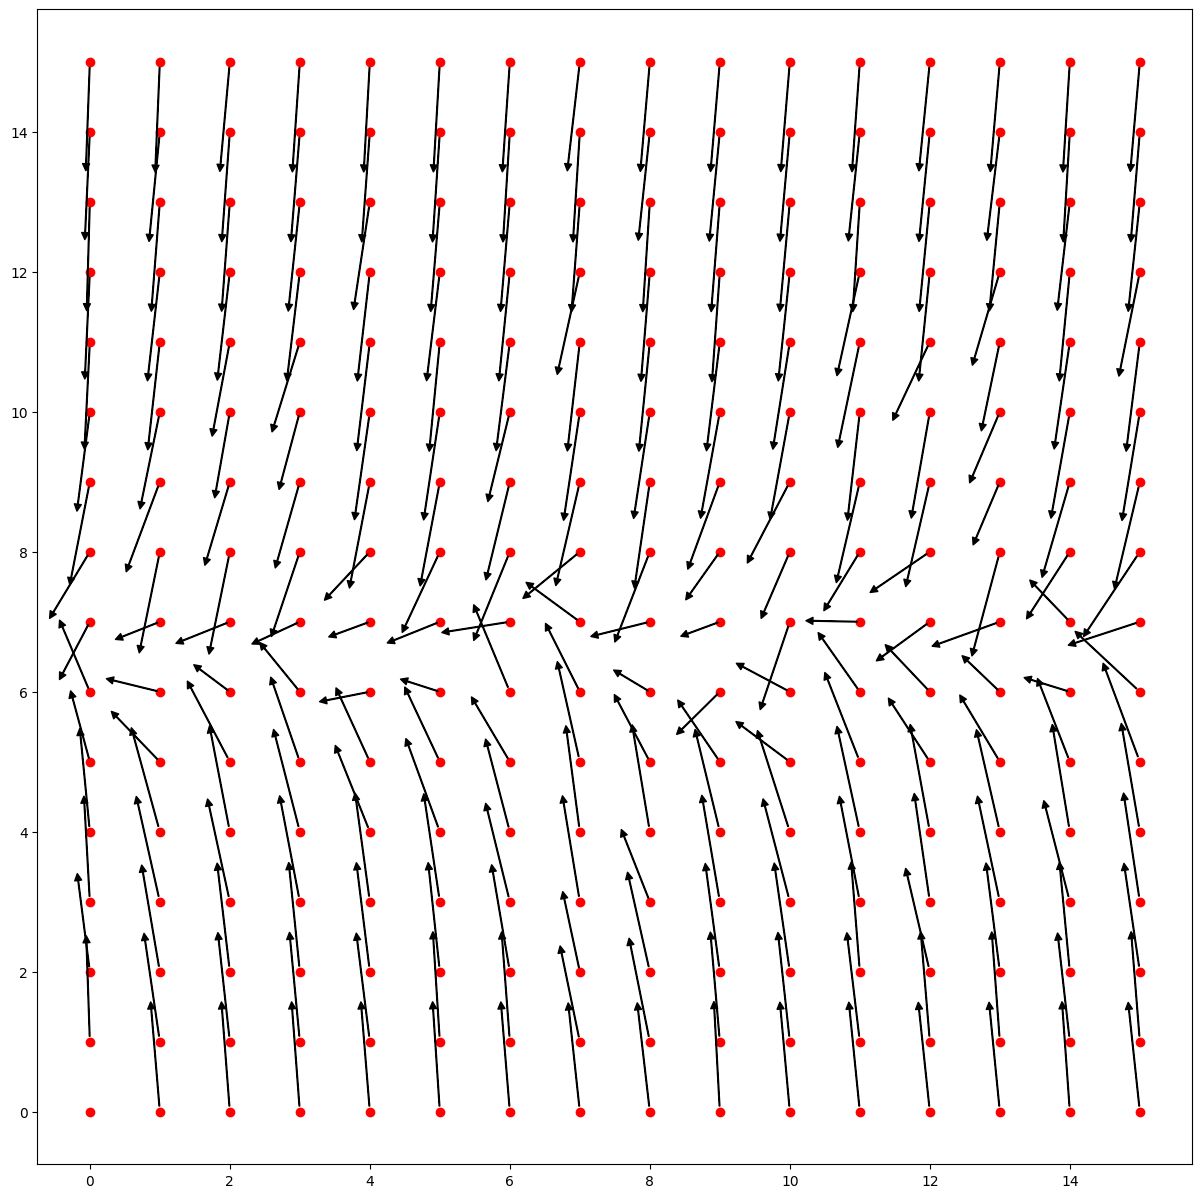

In [37]:
plot_data(average_events_per_n)